In [1]:
import pandas as pd
from transform import *

In [2]:
totals, sig_strikes, fight_details = extract("/../raw/")

In [3]:
sig_strikes = transform_sig_stikes(sig_strikes)

In [4]:
fight_details['round'] = fight_details['round'].apply(lambda x: x.split(":")[1]).astype(int)
fight_details['last_round_secs'] = fight_details['time'].apply(lambda x: int(x.split(":")[1])*60 + int(x.split(":")[2]))
fight_details['fight_time'] = fight_details.apply(lambda x: (x['round'] -1)*300 + x['last_round_secs'], axis = 1)

In [5]:
strikes_by_fight = sig_strikes.groupby(['url','name']).sum().reset_index()
strikes_by_fight.head()

,url,name,body_strikes,body_attempts,ground_strikes,ground_attempts,head_strikes,head_attempts,leg_strikes,leg_attempts,distance_strikes,distance_attempts,clinch_strikes,clich_attempts
0,http://www.fightmetric.com/fight-details/000da...,Josh Neer,1,2,7,9,17,36,1,1,7,21,5,9
1,http://www.fightmetric.com/fight-details/000da...,Joshua Burkman,9,12,5,10,22,72,4,4,14,50,16,28
2,http://www.fightmetric.com/fight-details/0027e...,Jared Rosholt,3,4,10,17,19,41,0,0,9,24,3,4
3,http://www.fightmetric.com/fight-details/0027e...,Josh Copeland,2,2,0,0,7,34,0,0,6,28,3,8
4,http://www.fightmetric.com/fight-details/00292...,Alistair Overeem,5,6,14,20,12,18,0,1,0,2,3,3


In [6]:
surv_df = pd.merge(fight_details, strikes_by_fight, on = 'url', how = 'left')
surv_df['KO'] = surv_df.apply(lambda x: x['name'] == x['winner'] and x['method']=="KO/TKO", axis = 1)

In [7]:
surv_df[surv_df['KO']][['name','bout','winner','loser','head_strikes']].head()

,name,bout,winner,loser,head_strikes
1,Tito Ortiz,Light Heavyweight Bout,Tito Ortiz,Ken Shamrock,15
3,Kendall Grove,Middleweight Bout,Kendall Grove,Chris Price,12
19,Roy Nelson,Ultimate Fighter 10 Heavyweight Tournament Tit...,Roy Nelson,Brendan Schaub,8
27,Matt Mitrione,Heavyweight Bout,Matt Mitrione,Marcus Jones,6
29,James McSweeney,Heavyweight Bout,James McSweeney,Darrill Schoonover,40


In [8]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/stephenma/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['extract', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [9]:
surv_df_3 = surv_df[surv_df['time_format'] == 'Timeformat:3Rnd(5-5-5)']

count    1145.000000
mean      320.957205
std       232.395470
min         7.000000
25%       127.000000
50%       274.000000
75%       481.000000
max       898.000000
Name: fight_time, dtype: float64


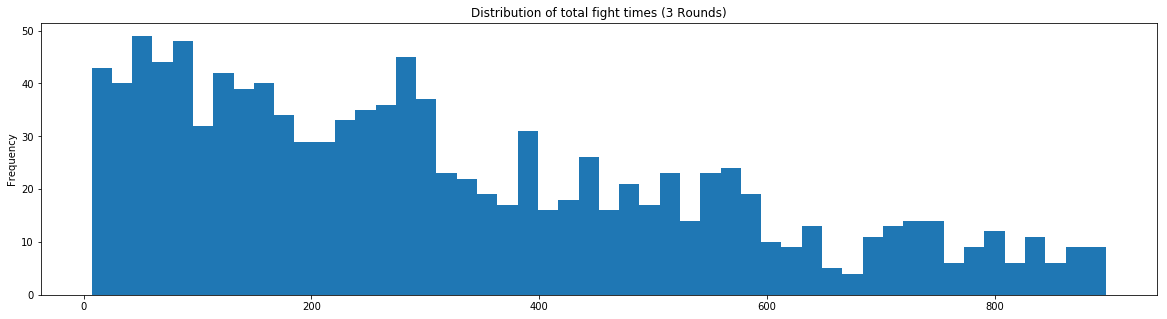

In [10]:
surv_df_3[surv_df_3['KO']]['fight_time'].plot(kind = 'hist', figsize = [20,5], bins = 50, 
                                              title = "Distribution of total fight times (3 Rounds)")
print surv_df_3[surv_df_3['KO']]['fight_time'].describe()

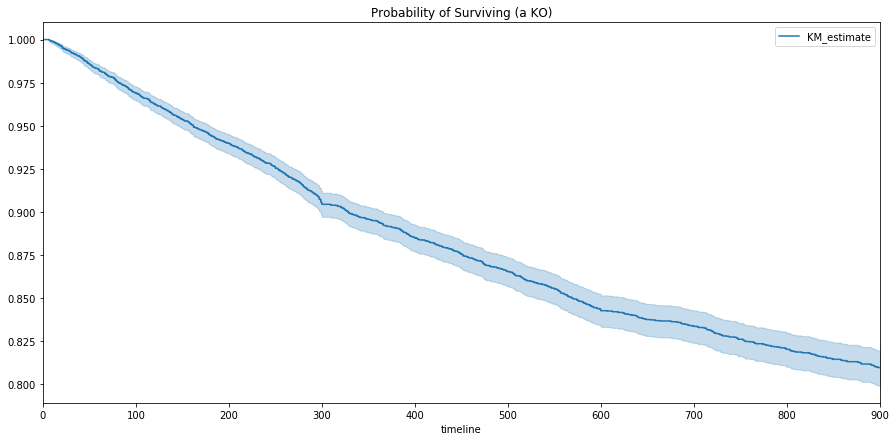

In [11]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

kmf.fit(surv_df_3['fight_time'], event_observed=surv_df_3['KO'])
kmf.plot(title = "Probability of Surviving (a KO)", figsize = [15,7])

/Users/stephenma/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


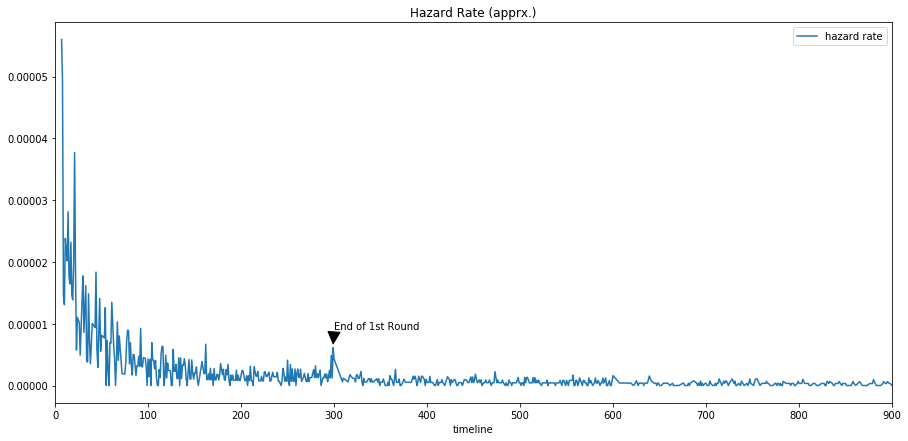

In [14]:
survival_func = kmf.survival_function_
shifted_survival_diff = (1 - survival_func/survival_func. shift(1))
hazard_empirical = shifted_survival_diff.div(survival_func.index.to_series(), axis=0)

hazard_empirical.columns = ['hazard rate']

ax = hazard_empirical.plot(title = "Hazard Rate (apprx.)",figsize = [15,7])

_ = ax.annotate('End of 1st Round', xy=(299, hazard_empirical.ix[299]*1.1), 
                xytext=(300, hazard_empirical.ix[299]*1.5),
            arrowprops=dict(facecolor='black', shrink=0.005))
